In [1]:
#!pip install pyfpgrowth
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import collect_set, col, count
from pyspark.ml.fpm import FPGrowth
#import pyfpgrowth

In [2]:
aisles = spark.read.csv("/FileStore/tables/aisles.csv", header=True, inferSchema=True)
departments = spark.read.csv("/FileStore/tables/departments.csv", header=True, inferSchema=True)
order_products_prior = spark.read.csv("/FileStore/tables/order_products__prior.csv", header=True, inferSchema=True)
order_products_train = spark.read.csv("/FileStore/tables/order_products__train.csv", header=True, inferSchema=True)
orders = spark.read.csv("/FileStore/tables/orders.csv", header=True, inferSchema=True)
products = spark.read.csv("/FileStore/tables/products.csv", header=True, inferSchema=True)

In [3]:
#Creating temporary view of the tables:

aisles.createOrReplaceTempView("aisles")
departments.createOrReplaceTempView("departments")
order_products_prior.createOrReplaceTempView("order_products_prior")
order_products_train.createOrReplaceTempView("order_products_train")
orders.createOrReplaceTempView("orders")
products.createOrReplaceTempView("products")

In [4]:
orders.show(5)

+--------+-------+--------+------------+---------+-----------------+----------------------+
order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
 2539329| 1| prior| 1| 2| 8| null|
 2398795| 1| prior| 2| 3| 7| 15.0|
 473747| 1| prior| 3| 3| 12| 21.0|
 2254736| 1| prior| 4| 4| 7| 29.0|
 431534| 1| prior| 5| 4| 15| 28.0|
+--------+-------+--------+------------+---------+-----------------+----------------------+
only showing top 5 rows

In [5]:
products.show(n=5)

+----------+--------------------+--------+-------------+
product_id| product_name|aisle_id|department_id|
+----------+--------------------+--------+-------------+
 1|Chocolate Sandwic...| 61| 19|
 2| All-Seasons Salt| 104| 13|
 3|Robust Golden Uns...| 94| 7|
 4|Smart Ones Classi...| 38| 1|
 5|Green Chile Anyti...| 5| 13|
+----------+--------------------+--------+-------------+
only showing top 5 rows

In [6]:
aisles.show(5)

+--------+--------------------+
aisle_id| aisle|
+--------+--------------------+
 1|prepared soups sa...|
 2| specialty cheeses|
 3| energy granola bars|
 4| instant foods|
 5|marinades meat pr...|
+--------+--------------------+
only showing top 5 rows

In [7]:
departments.show(n=5)

+-------------+----------+
department_id|department|
+-------------+----------+
 1| frozen|
 2| other|
 3| bakery|
 4| produce|
 5| alcohol|
+-------------+----------+
only showing top 5 rows

In [8]:
order_products_train.show(n=5)

+--------+----------+-----------------+---------+
order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
 1| 49302| 1| 1|
 1| 11109| 2| 1|
 1| 10246| 3| 0|
 1| 49683| 4| 0|
 1| 43633| 5| 1|
+--------+----------+-----------------+---------+
only showing top 5 rows

In [9]:
order_products_prior.count()  ## 32.4 million records

Out[167]: 32434489

In [10]:
order_products_prior.show(5)

+--------+----------+-----------------+---------+
order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
 2| 33120| 1| 1|
 2| 28985| 2| 1|
 2| 9327| 3| 0|
 2| 45918| 4| 1|
 2| 30035| 5| 0|
+--------+----------+-----------------+---------+
only showing top 5 rows

In [11]:
#Method 1:

df = orders.groupBy('order_hour_of_day').count().sort(col("order_hour_of_day").asc()).withColumnRenamed('order_hour_of_day', 'hour_of_day').withColumnRenamed('count', 'total_orders').show()

+-----------+------------+
hour_of_day|total_orders|
+-----------+------------+
 0| 22758|
 1| 12398|
 2| 7539|
 3| 5474|
 4| 5527|
 5| 9569|
 6| 30529|
 7| 91868|
 8| 178201|
 9| 257812|
 10| 288418|
 11| 284728|
 12| 272841|
 13| 277999|
 14| 283042|
 15| 283639|
 16| 272553|
 17| 228795|
 18| 182912|
 19| 140569|
+-----------+------------+
only showing top 20 rows

In [12]:
#Method 2:
df = sqlContext.sql("select order_hour_of_day as hour_of_day, count(order_id) as total_orders from orders group by order_hour_of_day order by order_hour_of_day")

In [13]:
display(df)

hour_of_day,total_orders
0,22758
1,12398
2,7539
3,5474
4,5527
5,9569
6,30529
7,91868
8,178201
9,257812


In [14]:
# Above line graph shows that the customers are more likely to place an order between 9 am to 6 pm.

In [15]:
%sql
select count(order_id) as total_orders, 
  (case 
     when order_dow = '0' then 'Sunday'
     when order_dow = '1' then 'Monday'
     when order_dow = '2' then 'Tuesday'
     when order_dow = '3' then 'Wednesday'
     when order_dow = '4' then 'Thursday'
     when order_dow = '5' then 'Friday'
     when order_dow = '6' then 'Saturday'              
   end) as day_of_week 
  from orders  
 group by order_dow 
 order by total_orders desc

total_orders,day_of_week
600905,Sunday
587478,Monday
467260,Tuesday
453368,Friday
448761,Saturday
436972,Wednesday
426339,Thursday


In [16]:
# Sunday and Monday have the most orders, while Thursday has the least orders in a week.

In [17]:
#Method 1:

df2 = orders.where(orders.days_since_prior_order.isNotNull()).groupBy('days_since_prior_order').count().sort(orders.days_since_prior_order.asc()).withColumnRenamed('count', 'total_orders').show()

+----------------------+------------+
days_since_prior_order|total_orders|
+----------------------+------------+
 0.0| 67755|
 1.0| 145247|
 2.0| 193206|
 3.0| 217005|
 4.0| 221696|
 5.0| 214503|
 6.0| 240013|
 7.0| 320608|
 8.0| 181717|
 9.0| 118188|
 10.0| 95186|
 11.0| 80970|
 12.0| 76146|
 13.0| 83214|
 14.0| 100230|
 15.0| 66579|
 16.0| 46941|
 17.0| 39245|
 18.0| 35881|
 19.0| 34384|
+----------------------+------------+
only showing top 20 rows

In [18]:
%sql

--Method 2
select days_since_prior_order, count(*) as total_orders
from orders
where days_since_prior_order IS NOT NULL
group by days_since_prior_order
order by days_since_prior_order 

days_since_prior_order,total_orders
0.0,67755
1.0,145247
2.0,193206
3.0,217005
4.0,221696
5.0,214503
6.0,240013
7.0,320608
8.0,181717
9.0,118188


In [19]:
# Let's create a master table joining order_products, products and departments table:

In [20]:
%sql

drop table if exists master_table;

In [21]:
%sql
create table master_table as
(select op.*,p.product_name,p.aisle_id,p.department_id,d.department from
 (select * from order_products_train 
 union
 select * from order_products_prior) as op
 inner join products as p
 on op.product_id = p.product_id
 inner join departments as d
 on p.department_id = d.department_id)

In [22]:
%sql
select *
from master_table
limit 5;

order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department
774,47482,1,0,Ice Cream Variety Pack,37,1,frozen
1139,21137,2,1,Organic Strawberries,24,4,produce
1591,22105,22,1,Ultra Thin Sliced Provolone Cheese,21,16,dairy eggs
2822,45970,16,0,Organic Black Beans Ready To Eat In Pouch,50,19,snacks
4677,12652,3,0,Advantage Oral-B Complete Deep Clean Soft Bristles Toothbrush,20,11,personal care


In [23]:
%sql
select a.total_items, count(a.total_items) as frequency
from
(
  select order_id,count(product_id) as total_items
  from master_table 
  group by order_id
) a
group by total_items
order by total_items

total_items,frequency
1,163593
2,194361
3,215060
4,230300
5,237224
6,236383
7,228548
8,211357
9,191563
10,172103


In [24]:
# The above bar chart depicts that the most common number of items purchased in order by customers is 4
# Majority of customers prefer to purchase between 1 to 15 items per order

In [25]:
%sql
select department, count(*) as orders_count from master_table
group by department
order by orders_count desc
limit 10

department,orders_count
produce,9888378
dairy eggs,5631067
snacks,3006412
beverages,2804175
frozen,2336858
pantry,1956819
bakery,1225181
canned goods,1114857
deli,1095540
dry goods pasta,905340


In [26]:
# If we take a look at top 10 departments from which most items are purchased, we would infer that more than 50% of the items purchased belong from just 2 departments which are ‘produce’ and ‘dairy eggs’

In [27]:
%sql
select product_name, count(*) as orders_count from master_table
group by product_name
order by orders_count desc
limit 100

product_name,orders_count
Banana,491291
Bag of Organic Bananas,394930
Organic Strawberries,275577
Organic Baby Spinach,251705
Organic Hass Avocado,220877
Organic Avocado,184224
Large Lemon,160792
Strawberries,149445
Limes,146660
Organic Whole Milk,142813


In [28]:
# These are the top 7 items bought by Instacart customers in their orders. Banana seems to be most bought commonly bought item in baskets followed by strawberries, baby spinach, avocado, etc.

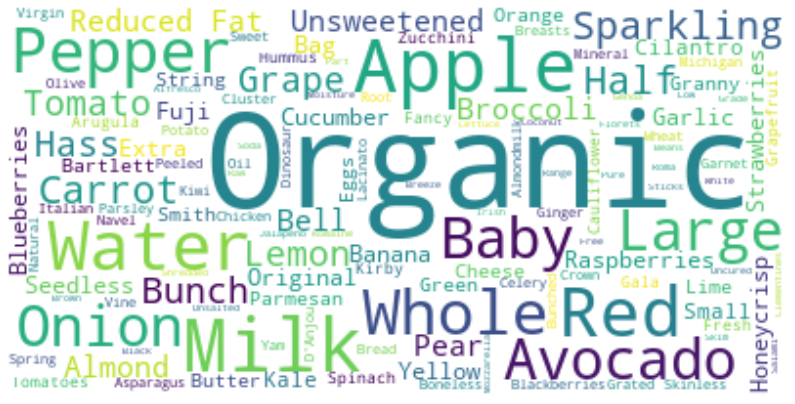

In [29]:
!pip install wordcloud

from wordcloud import WordCloud 
import matplotlib.pyplot as plt
df = sqlContext.sql("SELECT product_name FROM (select product_name, count(*) as orders_count from master_table group by product_name order by orders_count desc limit 100)")

df2 = df.rdd.flatMap(lambda x: x).collect()
fullStr = ' '.join(df2)
wordcloud = WordCloud(background_color="white").generate(fullStr)

# Display the generated image:
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
#From the word cloud, it appears that Americans buy organic food and veggies a lot as words like Organic, Milk, Water, Apple, Sparkling, Egg, Green, Cheese, etc. are getting highlighted the most.

In [31]:
rawData = spark.sql("select p.product_name, o.order_id from products p inner join order_products_train o where o.product_id = p.product_id")
rawData.show(10)

+--------------------+--------+
 product_name|order_id|
+--------------------+--------+
 Bulgarian Yogurt| 1|
Organic 4% Milk F...| 1|
Organic Celery He...| 1|
 Cucumber Kirby| 1|
Lightly Smoked Sa...| 1|
Bag of Organic Ba...| 1|
Organic Hass Avocado| 1|
Organic Whole Str...| 1|
Grated Pecorino R...| 36|
 Spring Water| 36|
+--------------------+--------+
only showing top 10 rows

In [32]:
baskets = rawData.groupBy('order_id').agg(collect_set('product_name').alias('items'))
baskets.createOrReplaceTempView('baskets')
baskets.show(10)

+--------+--------------------+
order_id| items|
+--------+--------------------+
 1342|[Raw Shrimp, Seed...|
 1591|[Cracked Wheat, S...|
 4519|[Beet Apple Carro...|
 4935| [Vodka]|
 6357|[Globe Eggplant, ...|
 10362|[Organic Baby Spi...|
 19204|[Reduced Fat Crac...|
 29601|[Organic Red Onio...|
 31035|[Organic Cripps P...|
 40011|[Organic Baby Spi...|
+--------+--------------------+
only showing top 10 rows

In [33]:
items = spark.sql("select items from baskets").toDF("items")
items_pandas_df = items.toPandas()

items.show(5)
items_pandas_df.head(5)

,items
0,"[Raw Shrimp, Seedless Cucumbers, Versatile Sta..."
1,"[Cracked Wheat, Strawberry Rhubarb Yoghurt, Or..."
2,[Beet Apple Carrot Lemon Ginger Organic Cold P...
3,[Vodka]
4,"[Globe Eggplant, Panko Bread Crumbs, Fresh Moz..."


In [34]:
fpGrowth = FPGrowth(itemsCol ='items', minSupport=0.001, minConfidence=0)
model = fpGrowth.fit(baskets)

In [35]:
# Display frequent itemsets.
model.freqItemsets.show(20)

+--------------------+-----+
 items| freq|
+--------------------+-----+
[Organic Tomato B...| 772|
[Organic Tomato B...| 175|
[Organic Tomato B...| 144|
[Organic Tomato B...| 179|
[Organic Spinach ...| 475|
[Whole Milk Ricot...| 347|
 [Medium Salsa Roja]| 275|
 [Ground Buffalo]| 231|
 [Tonic Water]| 194|
[Original Coconut...| 173|
[Low-Fat Strawber...| 152|
[Organic SprouTof...| 137|
 [Banana]|18726|
[Fruit Punch Spor...| 275|
[Kitchen Cheese E...| 230|
[Country White Br...| 194|
[Soft & Smooth Wh...| 173|
[Natural Liquid L...| 152|
[Bag of Organic B...|15480|
[Organic Large Gr...| 769|
+--------------------+-----+
only showing top 20 rows

In [36]:
#Display generated association rules.
model.associationRules.show(25)

+--------------------+--------------------+-------------------+------------------+
 antecedent| consequent| confidence| lift|
+--------------------+--------------------+-------------------+------------------+
[Broccoli Crown, ...| [Banana]| 0.3690773067331671|2.5860442347085395|
 [Sugar Snap Peas]|[Bag of Organic B...| 0.2207001522070015|1.8706619038067482|
[Organic Red Onio...|[Bag of Organic B...|0.34673366834170855|2.9389262202485296|
[Organic Red Onio...|[Organic Baby Spi...|0.22780569514237856|3.0550038280801664|
[85% Lean Ground ...| [Banana]| 0.235202492211838|1.6480125921511828|
[Organic Small Bu...|[Bag of Organic B...|0.36633663366336633| 3.105081612812444|
[Organic Zucchini...| [Large Lemon]|0.34615384615384615| 5.583097725875844|
[Organic Zucchini...|[Organic Baby Spi...|0.29554655870445345|3.9634473038688296|
[Organic Zucchini...| [Limes]|0.15368421052631578| 3.342408682073159|
[Organic Zucchini...| [Organic Avocado]|0.16210526315789472|2.8707881594930775|
[Organic Zucchini...| [Large Lemon]| 0.1957894736842105| 3.157878433021706|
[Organic Zucchini...|[Organic Strawber...| 0.2031578947368421|2.4468647154880037|
[Organic Zucchini...|[Bag of Organic B...| 0.2694736842105263|2.2840679994560045|
[Organic Zucchini...| [Banana]| 0.2326315789473684| 1.629998763329342|
[Organic Zucchini...| [Organic Cucumber]|0.15157894736842106| 4.311407349937819|
[Organic Zucchini...|[Organic Hass Avo...|0.17473684210526316| 3.14370578853551|
[Organic Zucchini...|[Organic Yellow O...| 0.1463157894736842| 4.47504625199362|
[Organic Zucchini...| [Organic Garlic]| 0.1463157894736842| 4.61711121237437|
[Sparkling Water ...|[Lime Sparkling W...|0.18627450980392157|12.431786448048191|
[Sparkling Water ...|[Sparkling Water ...|0.28431372549019607| 11.10584090736622|
[Sparkling Water ...|[Peach Pear Flavo...|0.18487394957983194| 26.98234265897683|
[Sparkling Water ...| [Banana]|0.19187675070028012|1.3444385657712834|
[Organic Grape To...|[Organic Strawber...| 0.3132530120481928|3.7728671248238776|
[Organic Grape To...|[Bag of Organic B...|0.41767068273092367| 3.540190737108641|
[Organic Grape To...|[Organic Baby Spi...| 0.2751004016064257| 3.689252718149786|
+--------------------+--------------------+-------------------+------------------+
only showing top 25 rows

In [37]:
#Transform examines the input items against all the association rules and summarize the consequents as prediction
model.transform(baskets).show(25)

+--------+--------------------+--------------------+
order_id| items| prediction|
+--------+--------------------+--------------------+
 1342|[Raw Shrimp, Seed...|[Organic Tomato B...|
 1591|[Cracked Wheat, S...|[Bag of Organic B...|
 4519|[Beet Apple Carro...| []|
 4935| [Vodka]| []|
 6357|[Globe Eggplant, ...|[Organic Tomato B...|
 10362|[Organic Baby Spi...|[Organic Strawber...|
 19204|[Reduced Fat Crac...|[Bag of Organic B...|
 29601|[Organic Red Onio...|[Organic Tomato B...|
 31035|[Organic Cripps P...|[Organic Tomato B...|
 40011|[Organic Baby Spi...|[Organic Tomato B...|
 46266|[Uncured Beef Hot...|[Organic Tomato B...|
 51607|[Donut House Choc...| []|
 58797|[Concentrated But...|[Organic Tomato B...|
 61793|[Raspberries, Gre...|[Hass Avocados, S...|
 67089|[Original Tofurky...|[Organic Tomato B...|
 70863|[Extra Hold Non-A...|[Limes, Organic W...|
 88674|[Organic Coconut ...|[Organic Cilantro...|
 91937|[No. 485 Gin, Mon...| []|
 92317|[Red Vine Tomato,...|[Bag of Organic B...|
 99621|[Organic Baby Aru...|[Limes, Organic W...|
 104688|[Shredded Sharp C...|[Organic Strawber...|
 106535|[Organic Extra La...|[Limes, Asparagus...|
 110904|[Organic Greek Pl...|[Bag of Organic B...|
 120988|[Raspberries, Clu...|[Banana, Organic ...|
 124647|[Pesto Cultured C...| []|
+--------+--------------------+--------------------+
only showing top 25 rows